# Multiplexing signals and generating AM signal

In [147]:
import numpy as np
import scipy.io.wavfile as iowav
from scipy import signal
import resampy
import matplotlib.pyplot as plt
import wave as wv

Fs Audio 1:  8000 
Fs Audio 2:  8000


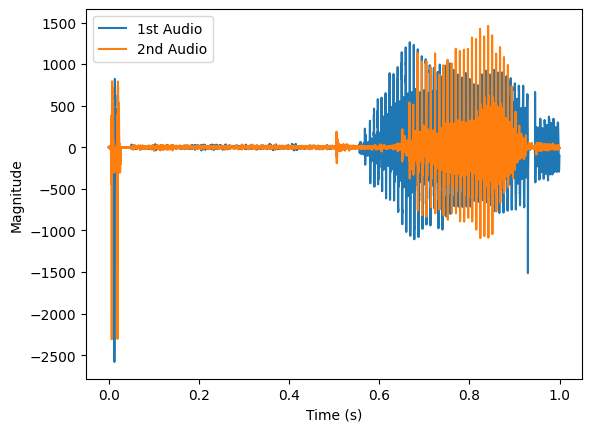

In [148]:
[Fs1, audio1] = iowav.read('../data/audio1.wav')
[Fs2, audio2] = iowav.read('../data/audio2.wav')
t = 1 # 10 seconds of audio
audio1 = audio1[0:t*Fs1]
audio2 = audio2[0:t*Fs2]
print("Fs Audio 1: ",Fs1,"\nFs Audio 2: ",Fs2)
plt.figure()
plt.plot(np.arange(len(audio1))/Fs1, audio1, label="1st Audio")
plt.plot(np.arange(len(audio2))/Fs2, audio2, label="2nd Audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

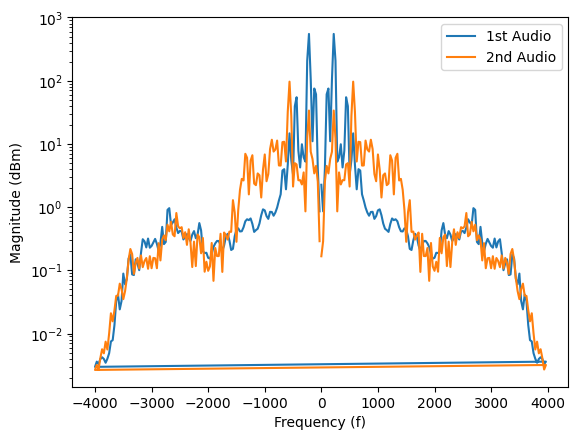

In [149]:
# Plot signal power and frequencies
xf1, yp1 = signal.welch(audio1, Fs1, return_onesided=False)
xf2, yp2 = signal.welch(audio2, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(xf1, yp1, label="1st Audio")
plt.semilogy(xf2, yp2, label="2nd Audio")
plt.legend()
plt.xlabel("Frequency (f)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Now let's analyze it using digital frequency, so let's remember the continuous to discrete frequency conversion:
$$ \omega=\Omega F_s $$
remembering that $\omega$ represents the continuous angular frequency in $\mathit{rad}/s$, $\Omega$ represents the discrete frequency in $\mathit{rad}$, and $F_s$ is the sampling frequency. We can also map the continuous angular frequency from $\mathit{rad}/s$ to $Hz$ using the relation $\omega=2\pi f$. Therefore, as we are representing our signal in $Hz$, we can calculate:
$$\Omega = \omega/F_s $$
$$\Omega = \frac{2\pi f}{F_s}$$
and now we have established a relation between the frequency in $Hz$ to a discrete frequency $\Omega$ in $\mathit{rad}$.

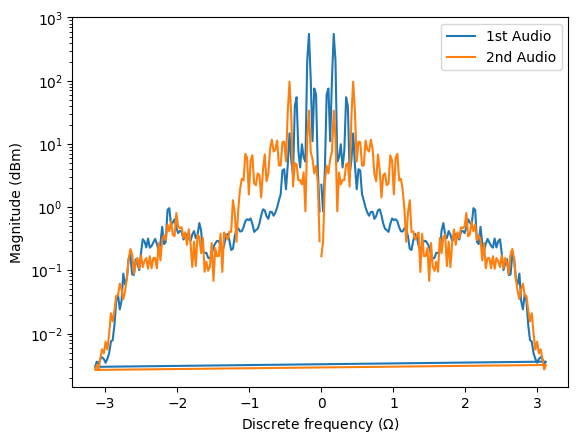

In [150]:
xf1_digi, yp1_digi = signal.welch(audio1, Fs1, return_onesided=False)
xf2_digi, yp2_digi = signal.welch(audio2, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(2*np.pi*xf1_digi/Fs1, yp1_digi, label="1st Audio") # We are converting frequency in Hz to discrete frequency in rad
plt.semilogy(2*np.pi*xf2_digi/Fs2, yp2_digi, label="2nd Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The maximum frequency of both audios is $f_{\mathit{max}}=4000Hz$ which is exactly the limit of the Nyquist sampling frequency $F_s/2 = 8000/2 = 4000 Hz$. Therefore we can calculate where $f_{\mathit{max}}$ will be mapped in the discrete domain $\Omega$ using:
$$ \Omega = \frac{2\pi f_{\mathit{max}}}{Fs} $$
$$ \Omega = \frac{2\pi f_{\mathit{max}}}{2f_{\mathit{max}}} $$
$$ \Omega = \pi $$

That's the reason why the frequency $4000 Hz$ was mapped to exactly $\pi=3.1415$ in the graph above.

An interesting aspect to take in consideration in the discrete domain is the copies of the signal that will appear in every $k 2 \pi$, so let's take a look at our signal considering these copies:

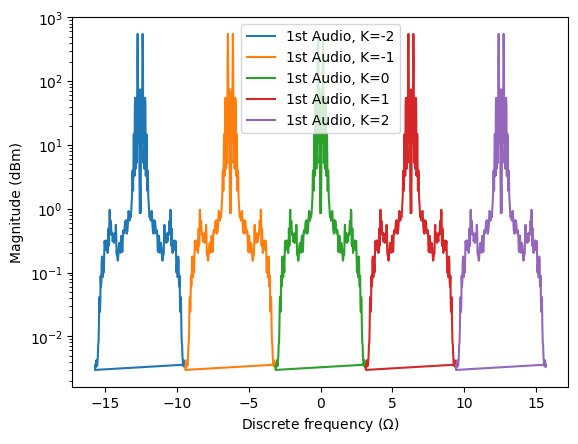

In [151]:
xf1_copies, yp1_copies = signal.welch(audio1, Fs1, return_onesided=False)
num_copies = 2
plt.figure()
for k in np.arange(-1*num_copies, num_copies+1):
	plt.semilogy(k*2*np.pi+2*np.pi*xf1_copies/Fs1, yp1_copies, label=f"1st Audio, K={k}") # We are including K in the x-axis
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The distance between copies of our signal are too close to each other that may cause troubles to filter or even generate inter-symbol interference (ISI) during the transmission. So, it is a good call to try to "separate" the copies by increasing the sampling frequency $F_s$ (we call it upsampling).

## Upsampling

In the upsampling process we increase the number of samples in our signal, reducing the bandwidth in the frequency domain, hence increasing the distance between the signal copies. We also filter the signal after since now the distance between copies are higher, and it is easy to project a filter to attend this new requirements.

We start creating `upsample_prefilter` and `downsample_prefilter` functions to insert/remove zeros from the signal (without filter) as depicted below.

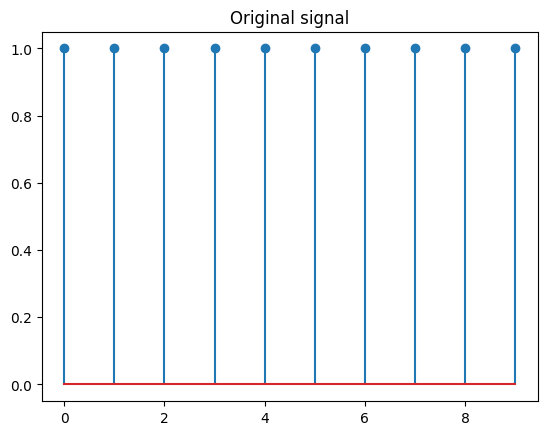

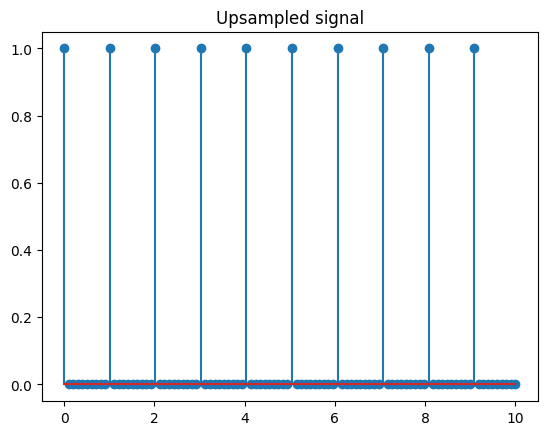

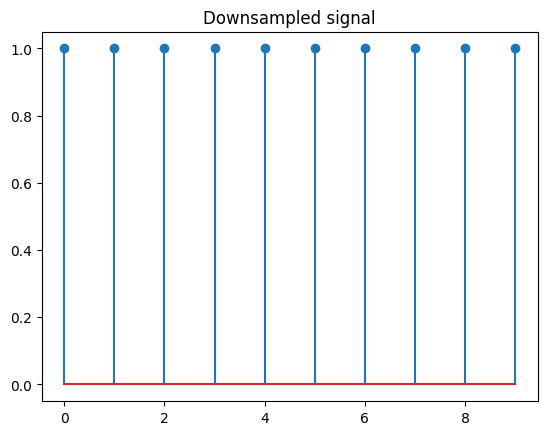

In [152]:
def upsample_prefilter(vector, factor):
	new_vector = np.zeros(len(vector)*factor)
	new_vector[::factor] = vector

	return new_vector

def downsample_prefilter(vector, factor):
	new_vector = vector[::factor]

	return new_vector

test = np.ones(10)
plt.figure()
plt.stem(test)
plt.title("Original signal")
plt.show()

U = 10
upsampled_test = upsample_prefilter(test, U)
plt.figure()
plt.stem(np.linspace(0,len(test), len(upsampled_test)), upsampled_test)
plt.title("Upsampled signal")
plt.show()

D=U
downsampled_test = downsample_prefilter(upsampled_test, D)
plt.figure()
plt.stem(np.linspace(0,len(test)-1, len(downsampled_test)), downsampled_test)
plt.title("Downsampled signal")
plt.show()

Now we apply our `upsample` function to the signal:

In [153]:
# Resampling signal
U = 10 # Upsampling factor
Fs_tx = U*Fs1
carrier_if = 600e3
carriers = np.array([610, 620]) * 1e3
BW_am = 5e3 # 5kHz baseband or 10 kHz passband
f_max = carriers[-1] - carrier_if + BW_am
audio1_resampled_pre_filter = upsample_prefilter(audio1, U)
audio2_resampled_pre_filter = upsample_prefilter(audio2, U)

Using the upsampĺing factor as $U=10$, we have reduced the original signal bandwidth by 10 times. So the bandwidth of $4kHz$ (or $\pi$) from the original signal was reduced to $4000/10=400Hz$ (or $\pi/10=0.314$).

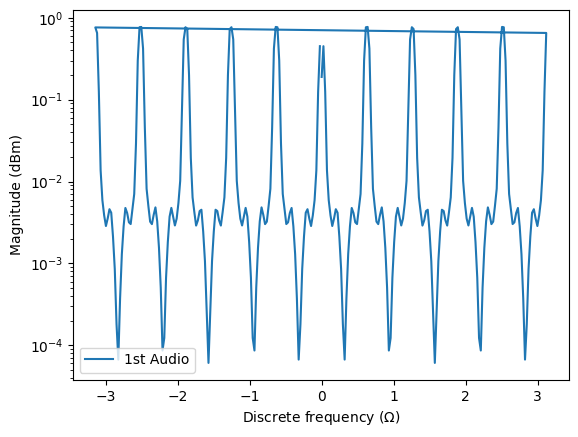

In [154]:
xf1_resample_pre_filter, yp1_resample_pre_filter = signal.welch(audio1_resampled_pre_filter, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(2*np.pi*xf1_resample_pre_filter/Fs_tx, yp1_resample_pre_filter, label="1st Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Besides the bandwidth reduction, copies of the original signal appeared on both sides, therefore we need to filter the signal to eliminate copies (creating a low-pass filter with bandwidth of $400Hz$ or $\pi/10 = 0.31415$ rad).

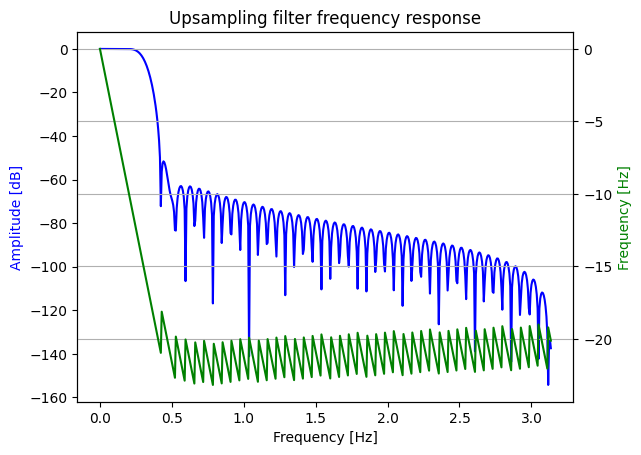

Group Delay:  49.499999999999964


In [172]:
# Upsampling filter
Foff = (np.pi/10)/np.pi # Filter cutoff frequency normalized by pi
filter_taps = 100
B_upsampling = signal.firwin(filter_taps,Foff, window = "hamming")
w, h = signal.freqz(B_upsampling)
fig, ax1 = plt.subplots()
ax1.set_title('Upsampling filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Frequency [Hz]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()
print('Group Delay: ', signal.group_delay((B_upsampling, 1))[1][0])

Filtering the signal, we obtain:

The upsampling increase the number of samples in our signal (different techniques could be applied to defined what should be the values of these new samples), so let's verify how this could affect the energy and power of our discrete signal. The energy of a discrete signal can be defined as:
$$\sum_{n=0}^{N-1}{|x^2|}$$

where $N$ is the total number of samples and $x$ refers to our audio signal. Therefore (considering that the audio values are given in Volts):

In [157]:

energy_signal = np.sum(np.power(audio1,2))
energy_resampled_signal = np.sum(np.power(audio1_resampled,2))
print(f"Audio 1 energy: {energy_signal} J\nAudio 1 resampled energy: {energy_resampled_signal} J")

Audio 1 energy: 7554063 J
Audio 1 resampled energy: 5925606632.65241 J


So the upsampling increased our signal energy (probably because the resample method used by Python does not add zero samples to increase the $F_s$, please read the [resample method doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html)). Now, let's take a look in our signal power (average energy since we are dealing with discrete signal):
$$ P_s = E_{avg} = \frac{\sum_{n=0}^{N-1}{|x^2|}}{N}$$

Therefore, the power can be calculated as:

In [158]:
avg_energy_signal = np.mean(np.power(audio1,2))
avg_energy_resampled_signal = np.mean(np.power(audio1_resampled,2))
print(f"Audio 1 Avg energy: {avg_energy_signal} J/sample\nAudio 1 resampled Avg energy: {avg_energy_resampled_signal} J/sample")

Audio 1 Avg energy: 944.257875 J/sample
Audio 1 resampled Avg energy: 74070.08290815512 J/sample


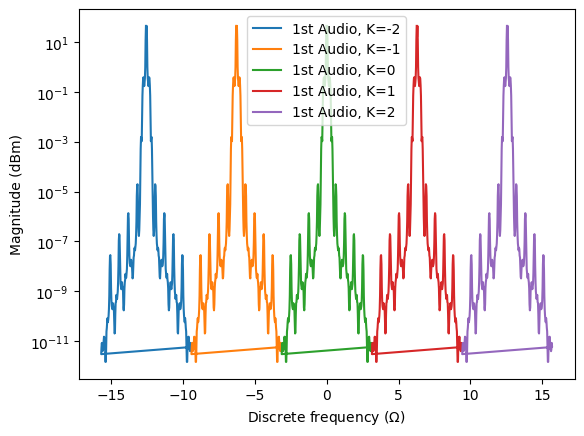

In [159]:
# Plot signal power and frequencies
num_copies = 2
plt.figure()
for k in np.arange(-1*num_copies, num_copies+1):
	plt.semilogy(2*np.pi*k+2*np.pi*xf1_resample/Fs_tx, yp1_resample, label=f"1st Audio, K={k}")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The graph above may seem keeping the same distance between signals as before upsampling, but it is important to take a look at the magnitude scale to realize that values smaller than 10^-3 are could be considered zero. So the distance between copies increased using upsampling process.

In [160]:
# Multiplexing signals x1 and x2 into x considering carrier frequencies 610kHz and 620kHz, respectively
h = 0.5
n = np.arange(0, t, 1/Fs_tx)
A1 = np.max(np.abs(audio1_resampled))/h
A2 = np.max(np.abs(audio2_resampled))/h
phase = np.pi
x = (A1+audio1_resampled)*np.cos(2*np.pi*n*carriers[0]+phase)+(A2+audio2_resampled)*np.cos(2*np.pi*n*carriers[1]+phase)

In [161]:
# Creating a noise in according to SNR value and inserting into signal x
SNR_db = 90
power_x = np.mean(np.power(x,2))
noise = np.sqrt(power_x/(np.power(10,SNR_db/10)))*np.random.randn(len(x))
noise_power = np.mean(np.power(noise,2))
rx = x#+noise
print(10*np.log10(power_x/noise_power))

90.00975866493356


# Demodulating AM signal

In [162]:
# Recovering from carrier frequency to the baseband
rbb1 = rx*np.cos(2*np.pi*n*carriers[0]+phase)
rbb2 = rx*np.cos(2*np.pi*n*carriers[1]+phase)

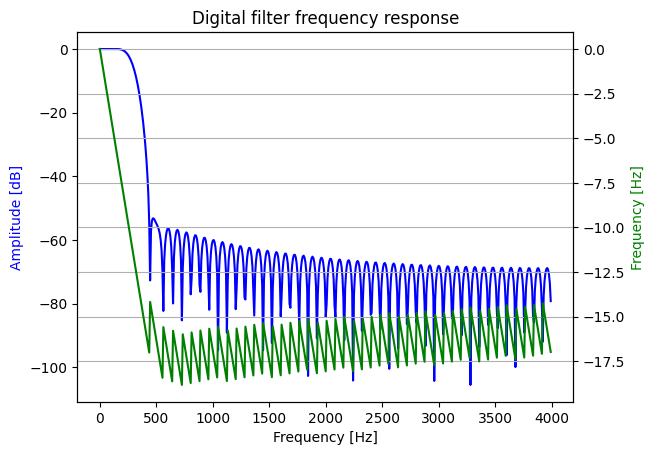

Group Delay:  49.499999999999986


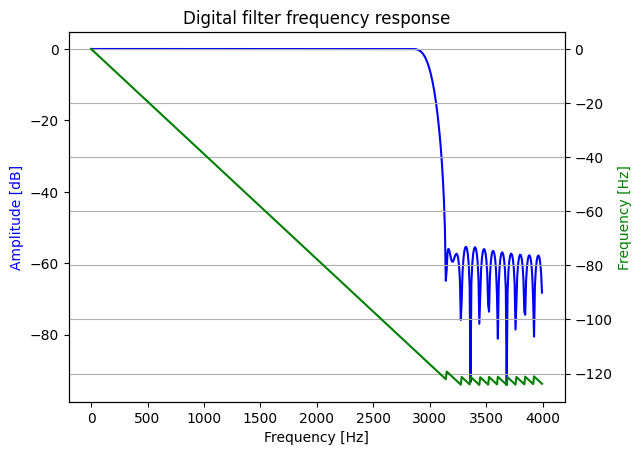

Group Delay:  49.499999999999964


In [163]:
# Filtering the signal at baseband
Foff = 3e3 # Filter cutoff frequency
filter_taps = 100
B = signal.firwin(filter_taps,Foff/(Fs_tx/2), window = "hamming")#, pass_zero = 'lowpass')
B2 = signal.firwin(filter_taps,Foff/(Fs1/2), window = "hamming")#, pass_zero = 'lowpass')
for filter in [B, B2]:
	w, h = signal.freqz(filter)
	fig, ax1 = plt.subplots()
	ax1.set_title('Digital filter frequency response')
	ax1.plot(w*Fs1/(2*np.pi), 20 * np.log10(abs(h)), 'b')
	ax1.set_ylabel('Amplitude [dB]', color='b')
	ax1.set_xlabel('Frequency [Hz]')
	ax2 = ax1.twinx()
	angles = np.unwrap(np.angle(h))
	ax2.plot(w*Fs1/(2*np.pi), angles, 'g')
	ax2.set_ylabel('Frequency [Hz]', color='g')
	ax2.grid()
	ax2.axis('tight')
	plt.show()
	print('Group Delay: ', signal.group_delay((filter, 1))[1][0])

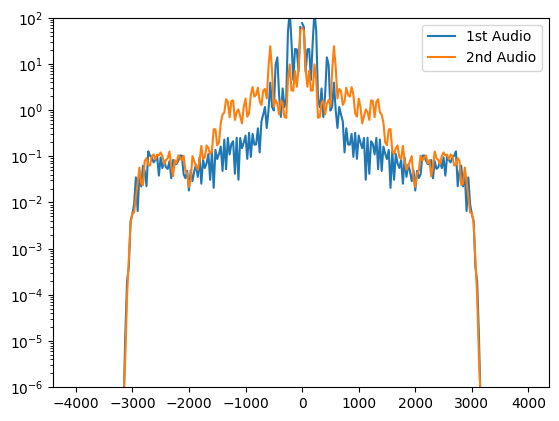

In [164]:
# Apply the filter on received signals with upsampling
rbb1 = signal.lfilter(B, 1, rbb1)
rbb2 = signal.lfilter(B, 1, rbb2)

# Resampling signals to 8kHz
rbb1_resampled = signal.resample(rbb1, int(Fs1*t))
rbb2_resampled = signal.resample(rbb2, int(Fs2*t))

# Using only the magnitude of the signal
mx1 = np.abs(rbb1_resampled)
mx2 = np.abs(rbb2_resampled)

# Filtering again using original FS
mx1_filtered = signal.lfilter(B2, 1, mx1)
mx2_filtered = signal.lfilter(B2, 1, mx2)

# removing average noise
mx1_denoised = mx1_filtered - np.mean(mx1_filtered)
mx2_denoised = mx2_filtered - np.mean(mx2_filtered)

fmx1, ymx1 = signal.welch(mx1_denoised, Fs1, return_onesided=False)
fmx2, ymx2 = signal.welch(mx2_denoised, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(fmx1, ymx1, label="1st Audio")
plt.semilogy(fmx2, ymx2, label="2nd Audio")
plt.ylim([1e-6, 1e+2])
plt.legend()
plt.show()
iowav.write('../data/test.wav', Fs1, (mx1_denoised).astype(np.int16))

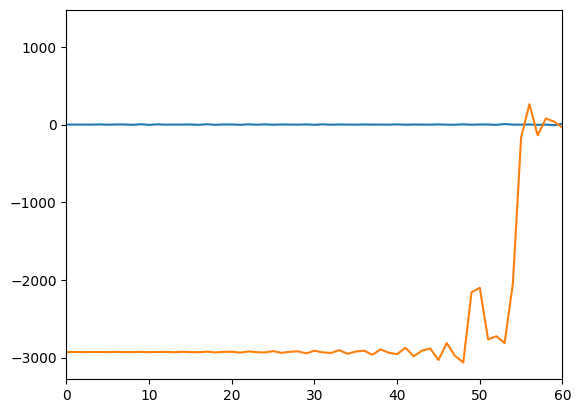

In [165]:
plt.figure()
plt.plot(audio1, label="Transmitted signal")
plt.plot(mx1_denoised, label="Received signal")
plt.xlim(0,60)
plt.show()

In [166]:
# Subtracting the mean of the signal (due to the addition of AM component at DC level, variables A1 and A2)
sig_filtered1 = sig_filtered1 - np.mean(sig_filtered1)
sig_filtered2 = sig_filtered2 - np.mean(sig_filtered2)

# removing filter group delay from filters
# sig_filtered1 = np.append(sig_filtered1[np.ceil(grp_delay*2).astype(np.int16):], np.zeros(np.ceil(grp_delay*2).astype(np.int16)))
# sig_filtered2 = np.append(sig_filtered2[np.ceil(grp_delay*2).astype(np.int16):], np.zeros(np.ceil(grp_delay*2).astype(np.int16)))

sig_filtered1 = np.append(sig_filtered1[22:], np.zeros(22))
sig_filtered2 = np.append(sig_filtered2[22:], np.zeros(22))

#normalização doida
sig_filtered1 = np.where(np.abs(sig_filtered1)>4000.0, 0, sig_filtered1)

NameError: name 'sig_filtered1' is not defined

In [ ]:

power_rcv_signal1 = np.mean(np.power(sig_filtered1, 2))
power_ori_signal1 = np.mean(np.power(audio1, 2))
power_noise1 = np.mean(np.power((sig_filtered1-audio1), 2))
snr_rcv_signal = 10*np.log10(power_rcv_signal1/power_noise1)
print('Power received signal 1 = ', power_rcv_signal1, '\nPower original signal 1 = ', power_ori_signal1, '\nPower noise 1 = ', power_noise1, '\nSNR 1 = ', snr_rcv_signal)

In [ ]:
plt.figure()
# plt.plot(np.arange(len(sig_filtered2))/Fs2, sig_filtered2, label="2nd Audio")
plt.plot(np.arange(len(audio1))/Fs1, audio1, '-y', label="1st Audio")
plt.plot(np.arange(len(sig_filtered1))/Fs1, sig_filtered1, '-b', label="1st received Audio")
plt.plot(np.arange(len(audio1))/Fs1, audio1-sig_filtered1, '-r', label="Error")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")

In [ ]:
y = np.correlate(sig_filtered1, audio1,"full")
plt.figure()
plt.plot(np.arange(-len(y)/2,len(y)/2), y)
plt.show()

In [ ]:
np.argmax(y)

In [ ]:
np.max(np.abs(audio1))

In [ ]:
np.max(abs(sig_filtered1))

In [ ]:
iowav.write('../data/test.wav', Fs1, (sig_filtered1).astype(np.int16))